# Data audit
 v3.0

This notebook analyze potential data sources in order to generate synthetic data for a population of Canadian Small and Medium size Enterprises (SME) across 18 sectors of the North American Industry Classification System (NAICS). The generator will focus on producing values for 10 financial indicators spanning on a timeframe of 36 months. We attemp to replicate, with a realistic degree of accuracy, the typical behaviour that those indicator observe within their respective sector.
In order to do so we will rely on a standard accounting a model that will be using historical values and estimates as seed to generate the synthetic data. 

Here are a few alternatives we will be exploring:
Data vendors: Bloomberg, Capital IQ, Refinitiv(DataStream) and FactSet, IBIS World
Open Data : StatCan, ISED (Innovation, Science And Economic Development Canada), SEDAR.



With respect to well established data vendor here is an overview of the services and pricing. 

**Bloomberg**: Supplies mostly publicly traded companies. The cost of a Bloomberg Terminal is \$27,660/year for one license.

**Capital IQ**: Supplies mostly publicly traded companies.	Pricing model is tier-based and tailored to meet the specific needs of each customer. Average packages average around \$13,500/year.

**FactSet**: At the time of writing, Factset did not supply us with a sample of their data, however, they claim the cover close to 3 million private company in North America 	The cost of a FactSet subscription is \$12,000 per year for the full product.

**Refinitiv Eikon**: Also known as datastream covers mostly publicly traded company financials. The cost of Eikon is \$22,000 per year, but a stripped-down version can cost as little as $3,600 per year.

**SEDAR** Access to this data is free.Private companies will report on a voluntary basis. However, for the purpose of this project, the use of this database is not feasible as there exist not aggregated reports by industry.

In the following we will take a closer look at the data contained in StatCan and ISED Canada and compeare then to the data from IBIS WOrld.

# StatCAN 
We can obtain a fairly accurate representation of the distribution of the canadian SME universe we use as input StaCan Table 
[3310066101](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3310066101).
We use a custom layout where select for following criterion:
Geography: All and Canada
Employment size : All (not including Total, with employee)
NAICS: Select only the 20 double digit sectors [11,21,22,23,31-33,44-45,48-49,51,52,53,54,55,56,61,62,71,72,81,91] (excluding

Once the proper features are selected, download the CSV for database loading.

The ouptut is a flat file that list the number of companies per sector per size bracket per province (and Canada).

A sample of this table can be found [on the Drive](https://drive.google.com/file/d/1OawsqHBBo0GgC8Hb7rqLzNPEQ0_io7Y8/view?usp=share_link).

The [VALUE] column contains the number of companies within a specific non overlapping cross section. Therefore, we can aggregate the value for any desired superset.



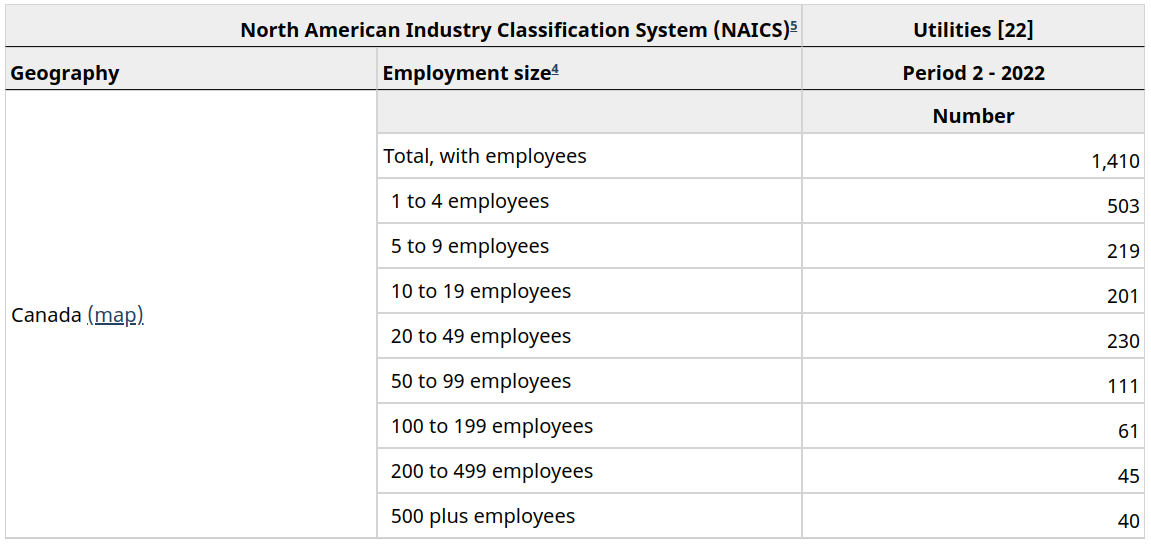

Downloading CSV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading into a dataframe

In [ ]:
import os
import pandas as pd
import numpy as np

myroot = '/content/drive/MyDrive/08 Cubeler/ALEX-Synthetic Data Generator v3.0/StatCan Tables'
myfile = r'3310066101_databaseLoadingData.csv'

In [ ]:
df = pd.read_csv(os.path.join(myroot,myfile))
df = df.drop(columns=['DGUID','UOM','UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE','STATUS','SYMBOL', 'TERMINATED', 'DECIMALS'])
df = df.rename(columns={'North American Industry Classification System (NAICS)': "NAICS"})

#Sanity check : **volumetrics**
total = df.groupby('GEO').get_group('Canada')['VALUE'].sum()

df_canada = df[df['GEO'] == 'Canada']
df['pct']=df['VALUE']/total

print(total,
      '=' ,
      df_canada.groupby('GEO').get_group('Canada')['VALUE'].sum(), '=',
      df['VALUE'].sum()
      )
print('2 =',df['pct'].sum())
print('Canada must sum to 1',df.loc[df['GEO'] == 'Canada', 'pct'].sum())
print('Total provinces must sum to 1',df.loc[df['GEO'] != 'Canada', 'pct'].sum())

1242907 = 1242907 = 2485814
2 = 2.0
Canada must sum to 1 0.9999999999999999
Total provinces must sum to 1 0.9999999999999999


Aggregating Small enterprise : All companies with less than 100 employees
and
Aggregating Medium enterprise : All companies between 100 and 499 employees

1st create new ['Size'] column to caracterise 'Small', 'Medium' or 'Large' enterprise 

In [ ]:
#df['Size'] = df['Employment size']
sz = {'1 to 4 employees'     : 'Small', 
      '5 to 9 employees'     : 'Small', 
      '10 to 19 employees'   : 'Small', 
      '20 to 49 employees'   : 'Small', 
      '50 to 99 employees'   : 'Small',
      '100 to 199 employees' : 'Medium', 
      '200 to 499 employees' : 'Medium',
      '500 plus employees'   : 'Large'
      }

df['Size']=df['Employment size'].map(sz) 

Aggregate table

In [ ]:
df = df.groupby(['GEO', 'Size', 'NAICS']).agg({'VALUE': ['sum'],'pct':['sum']}).reset_index()
df_canada = df[df['GEO'] == 'Canada']
df = df[df['GEO'] != 'Canada']

The dataframe excluding Canada

In [ ]:
df

,GEO,Size,NAICS,VALUE,pct
,,,,sum,sum
0,Alberta,Large,Accommodation and food services [72],7,5.631958e-06
1,Alberta,Large,"Administrative and support, waste management a...",27,2.172327e-05
2,Alberta,Large,"Agriculture, forestry, fishing and hunting [11]",1,8.045654e-07
3,Alberta,Large,"Arts, entertainment and recreation [71]",9,7.241089e-06
4,Alberta,Large,Construction [23],29,2.333240e-05
...,...,...,...,...,...
695,Yukon,Small,Real estate and rental and leasing [53],77,6.195154e-05
696,Yukon,Small,Retail trade [44-45],33,2.655066e-05
697,Yukon,Small,Transportation and warehousing [48-49],178,1.432126e-04


The dataframe only Canada

In [ ]:
df_canada

,GEO,Size,NAICS,VALUE,pct
,,,,sum,sum
120,Canada,Large,Accommodation and food services [72],40,0.000032
121,Canada,Large,"Administrative and support, waste management a...",216,0.000174
122,Canada,Large,"Agriculture, forestry, fishing and hunting [11]",13,0.000010
123,Canada,Large,"Arts, entertainment and recreation [71]",69,0.000056
124,Canada,Large,Construction [23],92,0.000074
125,Canada,Large,Educational services [61],478,0.000385
126,Canada,Large,Finance and insurance [52],144,0.000116
127,Canada,Large,Health care and social assistance [62],445,0.000358
128,Canada,Large,Information and cultural industries [51],91,0.000073


In order to get a better sense of the nature of the data, Let's consider other tables from ISED Canada and compare them to statCan counterpart.

Consider for example the following tables which shows the number of companies:
at https://www.ic.gc.ca/app/scr/app/cis/summary-sommaire/44-45

and

https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3310066101

The first tables contains 1410 companies whereas the second than contains 4928

The differences of approximately 3500 stems from non-employer or indeterminate establishments that do not maintain an employee payroll.

We recommend you exercise caution when using the establishment counts for both employment types in combination. The data is collected from different sources. Added together the two employment types do not necessarily make up the universe of companies. The “Employers” category includes all companies both incorporated and unincorporated businesses. However, the “non-employers / indeterminate” category includes all incorporated businesses but only includes the unincorporated businesses with annual revenues over $30,000 (non-taxable and taxable). You should also note that companies that only have contract workers with no employee payroll are included in the “non-employers / indeterminate” category.

ISED Canada produces Financial performance Data:
[link](https://ised-isde.canada.ca/app/ixb/fpd-dpf/profilestart?lang=eng)
Here is an example of the tables:
[Google Drive](https://docs.google.com/spreadsheets/d/1e3ZWSkGgD_EKKCl0Cyu9qL0cJy7AF-dQ/edit?usp=share_link&ouid=101607963363110529022&rtpof=true&sd=true)

For retail sector here is an overview and the break down...
The retail industry in Canada has 230K establishments. Of those, 98K are non employers, leaving us with 132K establishments. Of those 132K, 60% are small enterprises, 2.7% are medium sized and 0.1% are large. The remaining 37.5% in for micro sized (less than 5 employees).



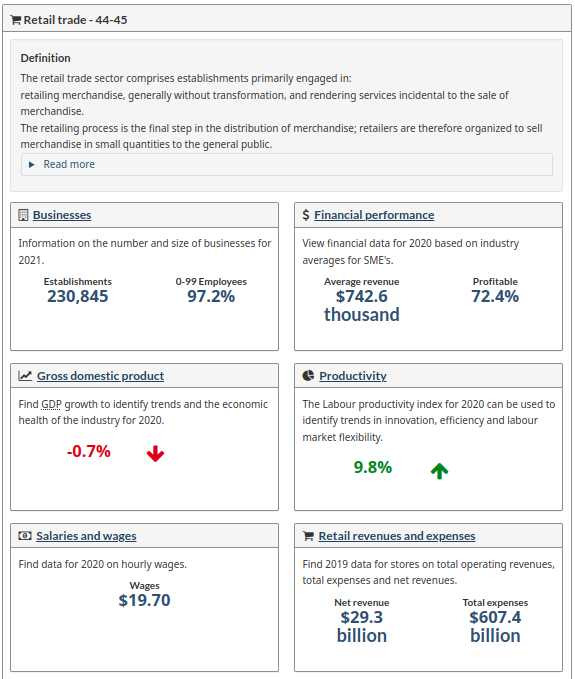

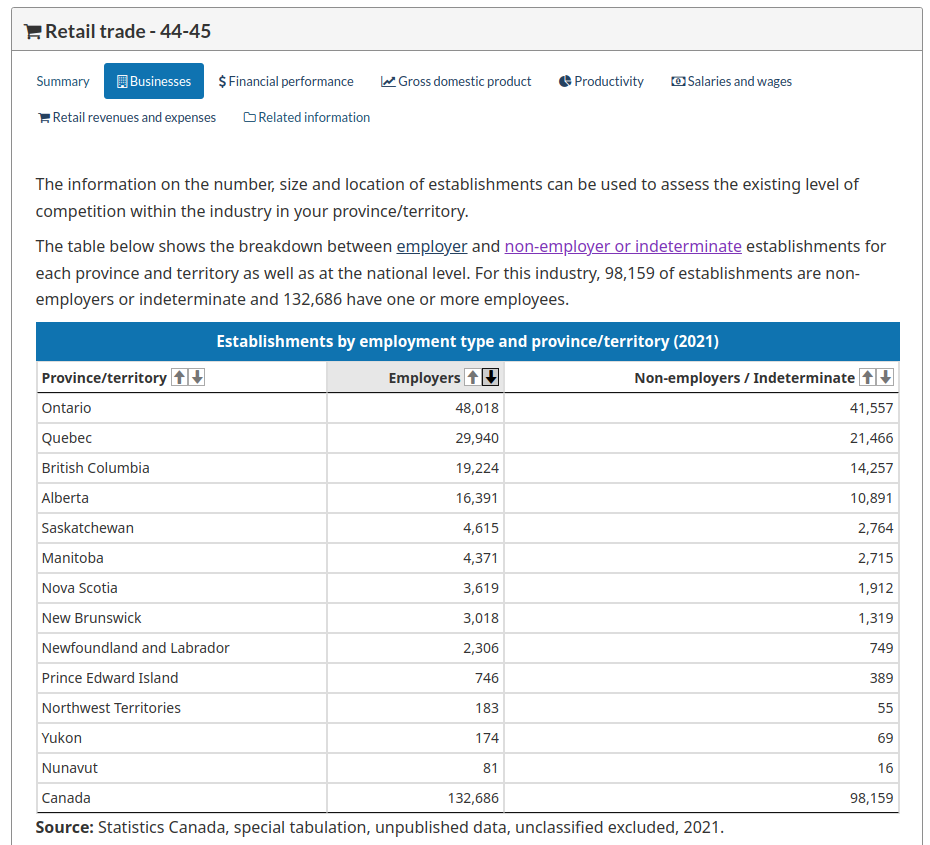

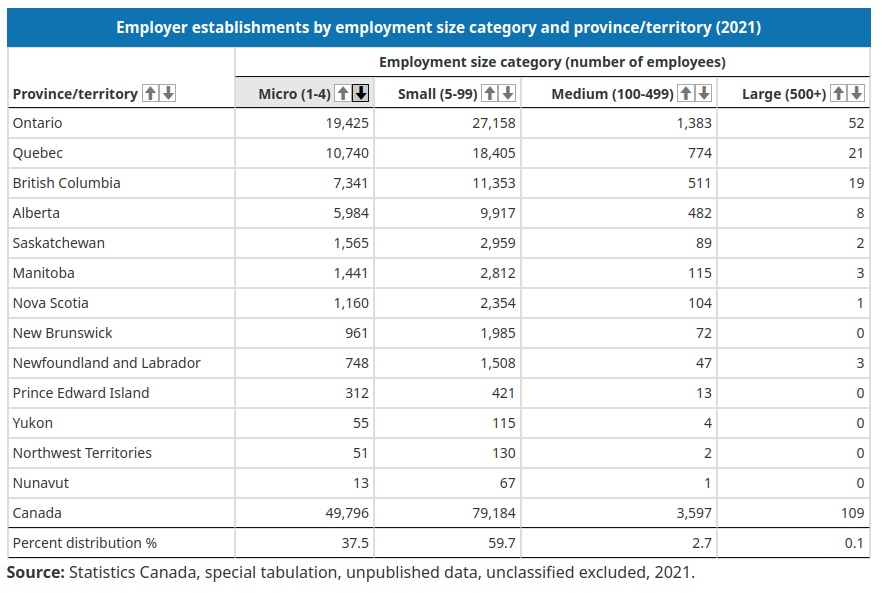

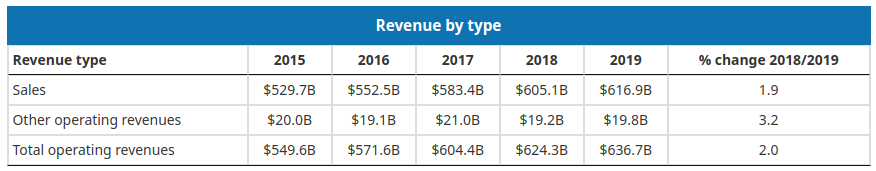

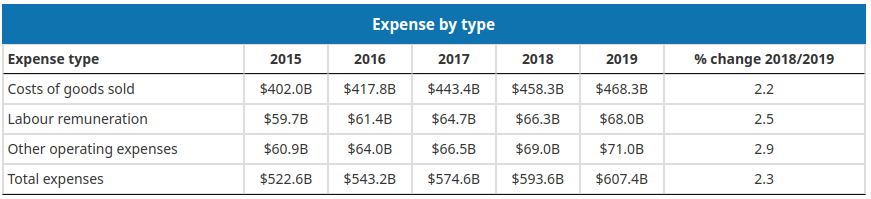

We can download ISED data for unfortunately they segment the data differently. Instead of segmenting company size by employee count, they use revenue categories. Between \$30k and \$5M an between \$5M and \$20M revenu. Depending on the type and size of the companies, we can obtain fair amount of indicators of interest. In the retail space, for example. The following tables illustartes some of the available indicators. Note that the values in those tables do not reconciliate nicely with the previous numbers because company are segmented using different factors.

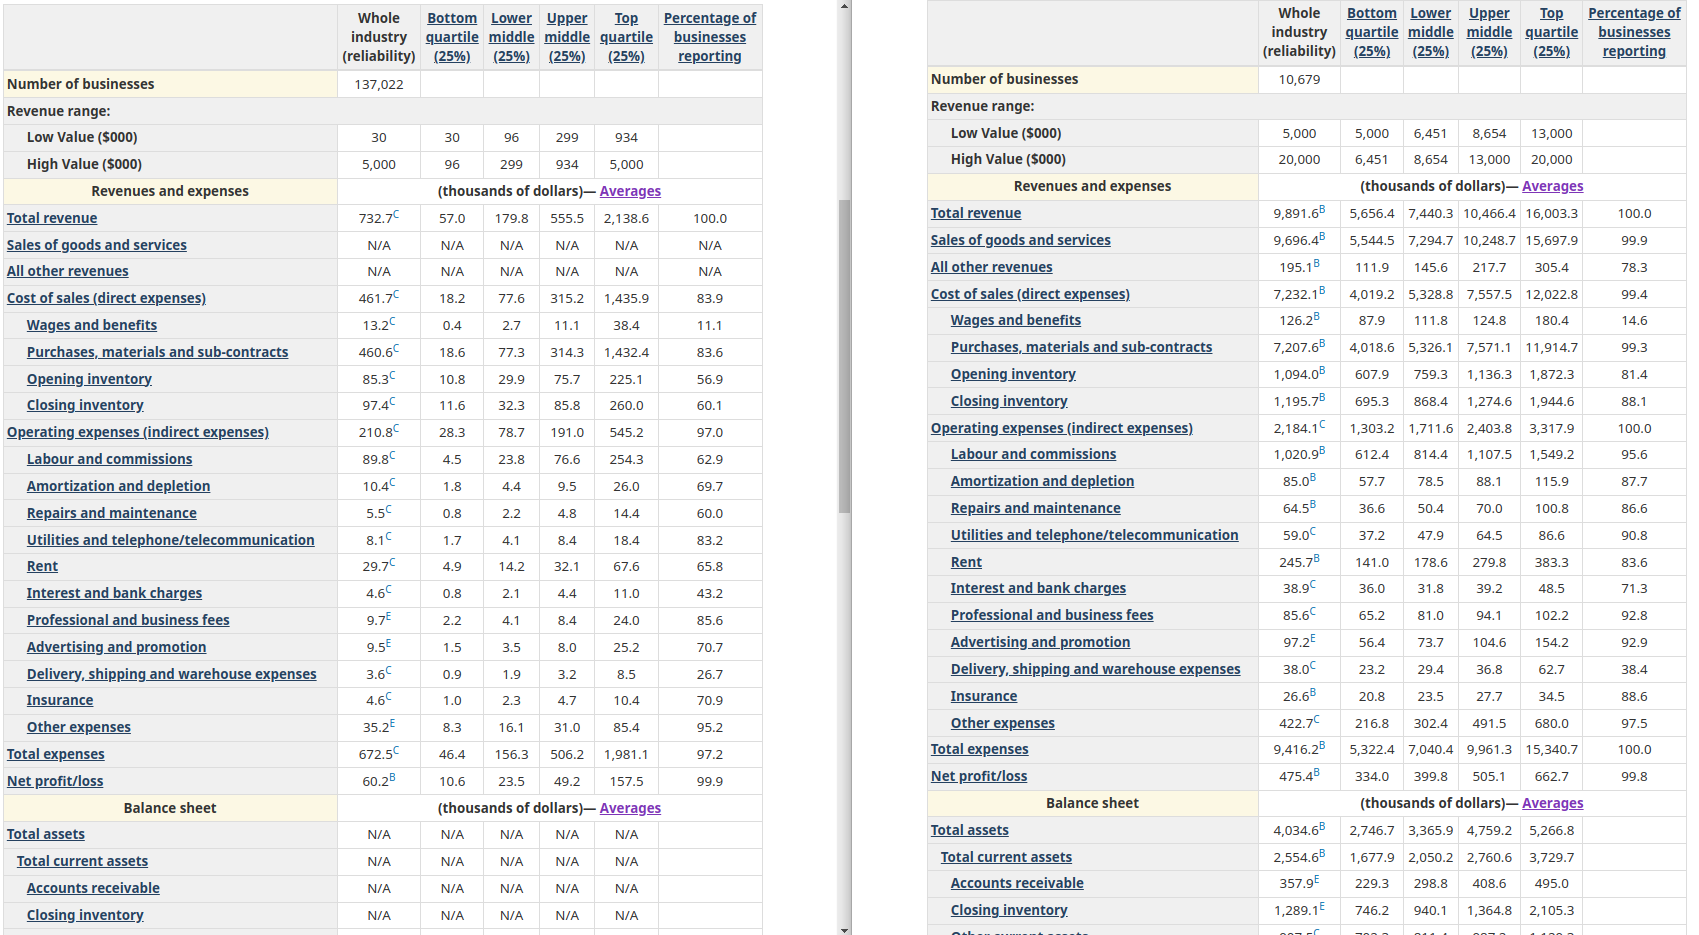

Missing indicators are marked in bold
▪ Total Sales

▪ Total Expenses

▪ **Accounts Payable**

▪ Accounts Receivable

▪ **Cash and Cash Equivalents**

▪ Cost of Goods Sold

▪ Inventory

▪ Current Assets

▪ Fixed Assets *obtainable with fixed asset to equity ratio*

▪ Total Assets

#IBIS World Data

IBIS supplies data at the industry level only.
Overall they have 431 reports that cover 18 sectors. this means that if we want to derive information, we will have to manually download 431 documents and parse them for the relevant data and than aggregate them to get an approximation of the sectors level values.

Here are a curated selection of the relevant measure offered by IBIS

* Revenue 
* Establishments or Enterprises
* Employment
* Wages
* Revenue Volatility
* Business and revenu concentration
* Growth rate for Establishments, 
* Revenue, 
* Employment
* Wages

There are key missing indicators with respect to balance sheet items like Asset liability, cash and payables/receivables.



We will compare the value contained in IBIS World data vs ISED/StatCan.
First we notice that IBIS does not use the NAICS Nomenclature calling 45299 Dolar and variety stores instead of ALl other general Merchandise store.
Second, we notice that the values contained in IBIS are at first glance the same as ISED as they seem to be using the same source. IBIS does provide the historic data that seem harder to get on .

We do have to be carefull when using IBIS data. For example, if we look at **key statistics**, we will notice that the industry revenue is almost \$7B, which includes large companies, as evidenced by the Dollorama financial performance (revenue of \$4B), whereas the ratio sections looks only at small and medium companies.

**IBIS**
CANADA INDUSTRY (NAICS) REPORT 45299CA / RETAIL TRADE IN CANADA
Dollar & Variety Stores in Canada 
**ISED-Canada**




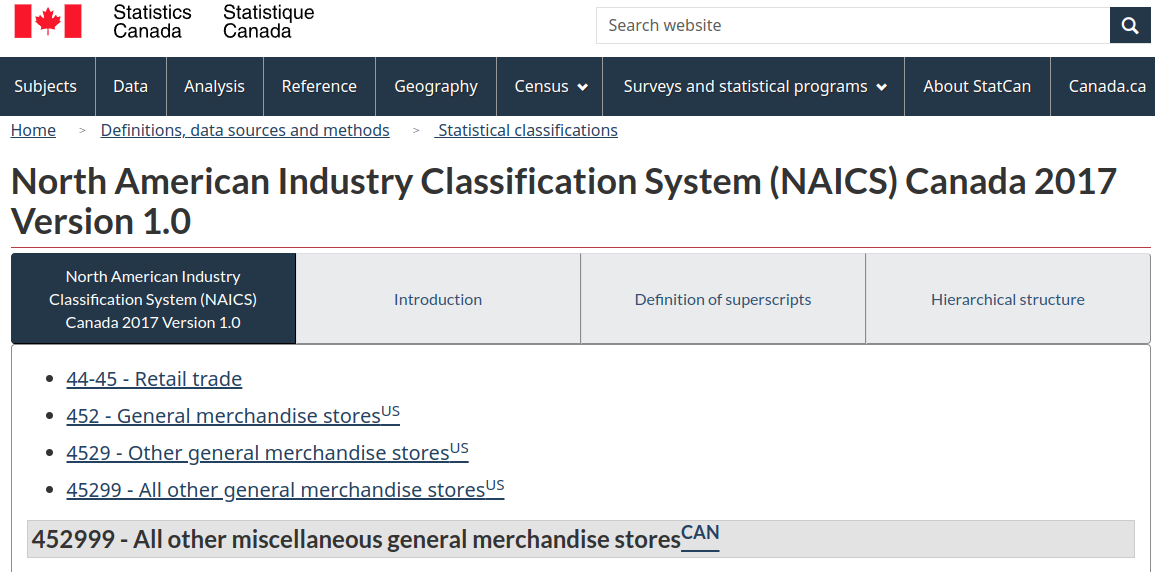

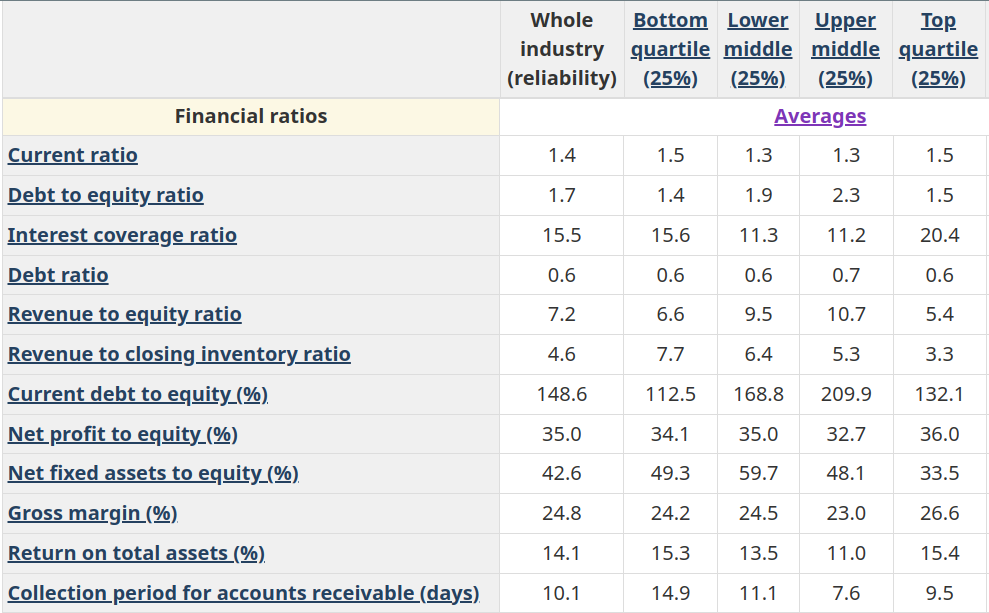

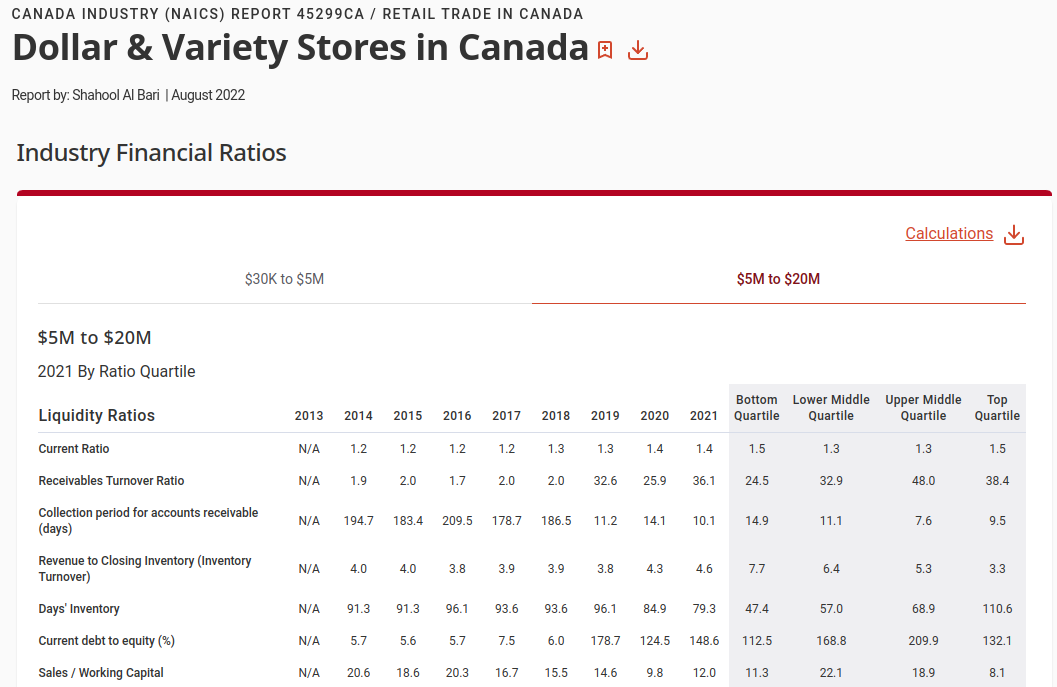

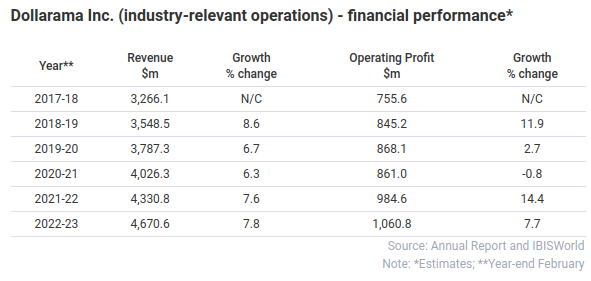

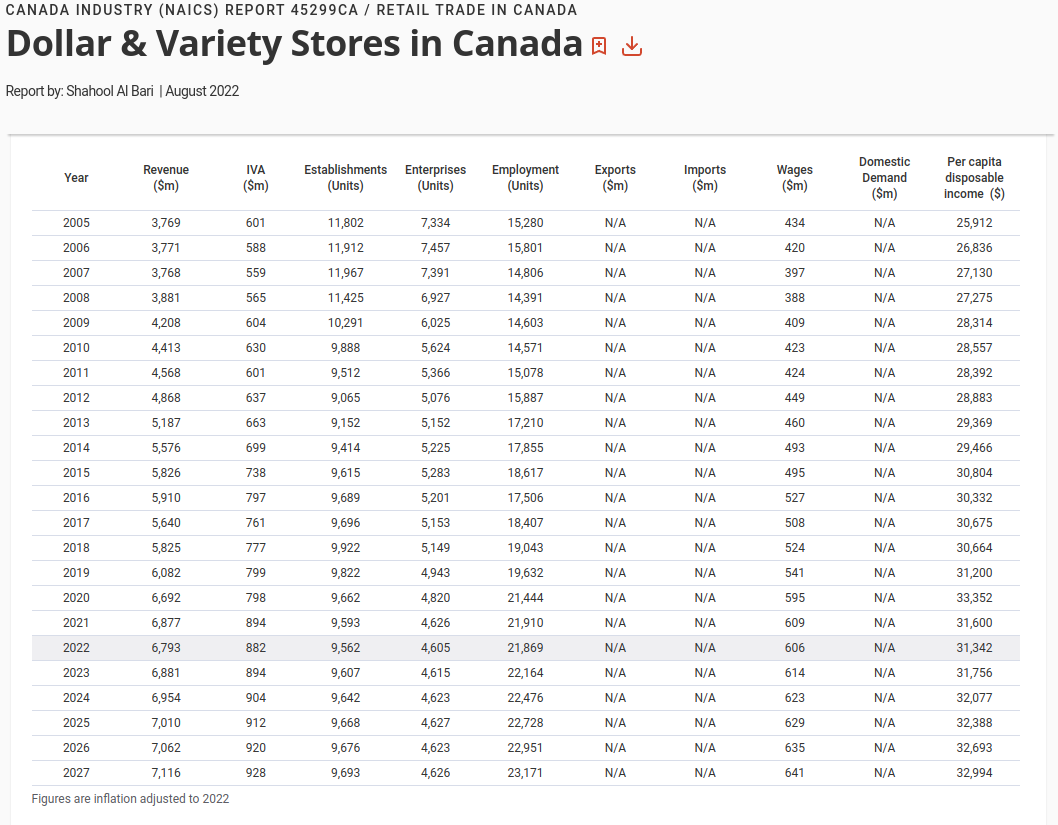

**NOTE:** ISED Canada: Certain NAICS segments are not populated. For example NAICS 4521 - Department stores for small business between \$30k and \$5000k *The data has been suppressed due to confidentiality*, and the medium size segment between \$5M and \$20M has no components. This also implies that all the child below will also not return results.

In conclusion we can use IBIS WOrld data in conjunction with ISED Canada data to genereate synthethic data, as long as we use proper precautions to mitigate the issues highlighted above.